Connected to base (Python 3.11.4)

### 1. Making Classification data and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [ ]:
len(X), len(y)

In [ ]:
print(f"First five samplex of X:\n {X[:5]}")
print(f"First five samplex of y:\n {y[:5]}")

In [ ]:
# Make DataFrame of circle Data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

In [ ]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

In [ ]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

##### 1.1 Turn data into tensors and create train and test splits

In [ ]:
# Turn data into tensors
import torch

In [ ]:
type(X)

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

In [ ]:
# Split to Training and Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, #That means 20% of test data
                                                    random_state = 42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

### 2. Build a model

* 1. Setup device agonistic code so our code will run on an accelerator(GPU) if there is one
* 2. Construct a model(by subclassing nn.Module)
* 3. Define a loss function and optimizer
* 4. Create a training and Test Loop

In [ ]:
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

* Create a model that:

    1. SubClasses 'nn.Module'
    2. Create 2 'nn.Linear()' -> Layers that are capable of handling the shapes of our data
    3. Defines a 'forward()' -> method that outlines the forward pass (or forward computation)
    4. Instanciate an instance of our model class and send it to the target device

In [ ]:
# 1. Construct a model that SubClass 'nn.Module'
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscale  to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # layer 1 out_features should match with in_features of layer 2
    
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
# 4. Instanciate an instance of our model
model_0 = CircleModelV0().to(device)
model_0

TRY TO UNDERSTAND LAYERS : https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.98497&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

In [ ]:
# Replicate model above using nn.Sequenstial

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

In [ ]:
# Make prediction
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
    print(f"\nFirst 10 labels:\n{y_test[:10]}")

##### 2.1 Setup loss function and optimizer

* Loss: 
For classification you might want BinaryCrossEntropy or CategoricalCrossEntropy(CrossEntropy)

* Optimization:
SGD or ADAM however PyTorch has many built-in options


For the loss function we are going to use 'torch.nn.BCEWithLogitsLoss()', for more on what binary cross entropy (BCE) is, check out this article: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [ ]:
# Setup loss function
    # loss_fn = nn.BCELoss() # requires input to have gone through the sigmoid activation function before
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid Activation function built-in

optimizer = torch.optim.SGD(params= model_0.parameters(), lr=0.1)

In [ ]:
# Calculate accuracy -> out of 100 examples what percantage does our model get right
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 3 Train model
To train our model, we're going to need to build a training loop

* 1. Forward Pass
* 2. Calculate the loss
* 3. Optimizer zero grad
* 4. Loss backward (backpropagation)
* 5. Optimizer step (gradient descent)

##### 3.1. Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are hoing to be raw (logits)

We can convert these (logits) into prediction probabilities  by passing them to some kind of activation function(e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert it to prediction labels by either rounding them or taking the 'argmax()'

In [ ]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

In [ ]:
# Use 
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

In [ ]:
# Find predicted labels
y_preds = torch.round(y_preds_probs)

# In full (logits -> pred prob -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

##### 3.2 Make test and train loop

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


### 4 Make prediction and evaluate model

From metrics it looks like our model isn't learning anything..

So to inspect it we'll make predictions and make them visual

To do so, we're going to import a function called 'plot_decision_boundary()'

In [ ]:
import requests
from pathlib import Path

# Download helper functions from learn PyTorch repo
if Path('helper_functions.py').is_file():
    print("helper_functions already exist")
else:
    print("Downloading helper_functions")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5 Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation function
* Change the learning rate
* Change the loss function

These are options all from model perspective because they deal directly with the model, rather than the data

And because all this values we can change they are called 'HypperParameters'

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # Good
        # z = self.layer1(x)
        # z = self.layer2(z)
        # z = self.layer3(z)

        # Better
        return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42) 

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad() 

  # 4. Loss backward (backpropagation) 
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) 
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
     

In [ ]:
# Plot decision boundary 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

##### 5.1 Prepating data to see if our model can fit a straight line

one way to troubleshoot to a larger problem is to test out a smaller problem.


In [ ]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

In [ ]:
# Create train and test Splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

##### 5.2 Adjusting 'model_1' to fit a straight line


In [ ]:
# Same architecture as model_1
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

In [ ]:
# Loss and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

#Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    
    # Print
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss {test_loss:.5f}")

In [ ]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

### 6 Non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

##### 6.1 Recreating non-linear data


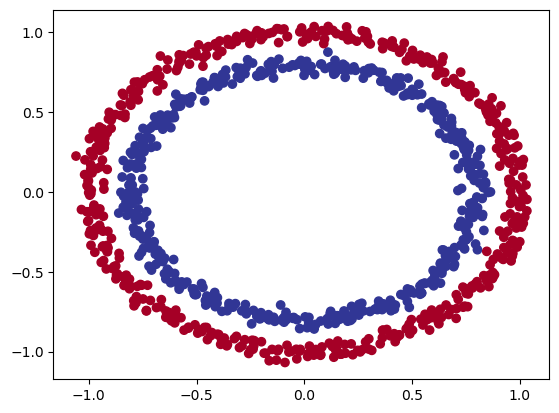

In [120]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise= 0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [121]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=42)

len(y_train), len(y_test)

(800, 200)

##### 6.2 Building non-Linear model

In [122]:
# Building model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() #<-- relu is a non-linear activation function

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    
model_3 = CircleModelV2()

In [123]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr = 0.1)

##### 6.3 Training a model with non_linearity

In [124]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 2000

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test Acc: 50.00%


Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Test Acc: 79.00%
Epoch: 1000 | Loss: 0.5682, Acc: 87.75% | Test Loss: 0.5738, Test Acc: 86.50%
Epoch: 1100 | Loss: 0.4815, Acc: 93.50% | Test Loss: 0.4993, Test Acc: 90.50%
Epoch: 1200 | Loss: 0.3706, Acc: 97.75% | Test Loss: 0.4059, Test Acc: 92.00%
Epoch: 1300 | Loss: 0.2546, Acc: 99.00% | Test Loss: 0.3033, Test Acc: 96

##### 6.4 Evaluating a moodel trained with non-linear activation functions

In [125]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

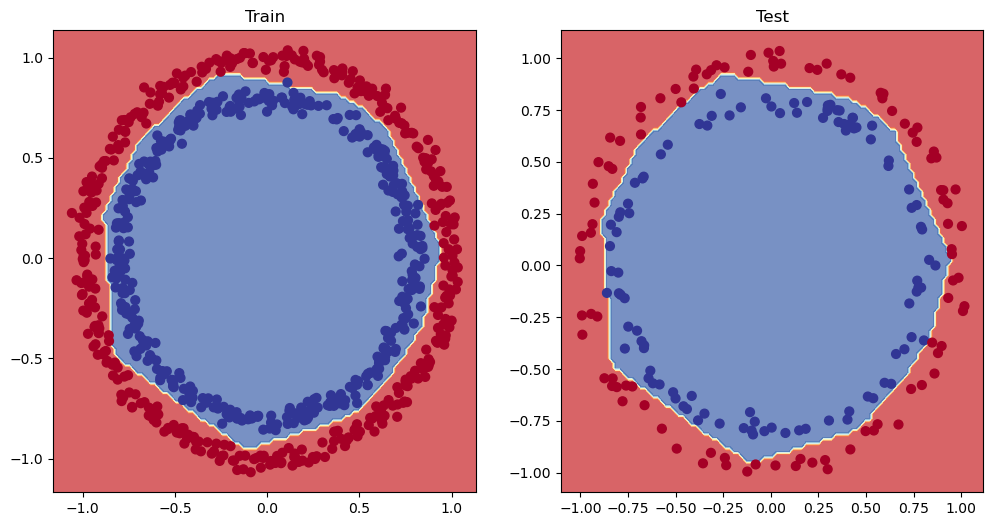

In [126]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)